In [1]:
import os
### QAOA_realestate가 있는 폴더로 지정
dir_path = "/Users/minhyeong-gyu/Documents/GitHub/QuantumVariableSelection"
os.chdir(dir_path)
import sys
module_path = dir_path + "/Module"
if module_path not in sys.path:
    sys.path.append(module_path)

from optimizer import optimizer as opt
from optimizer import basefunctions as bf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import font_manager, rc
# 윈도우 한글 폰트
# font_path = "C:/Windows/Fonts/NGULIM.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)

# Mac 한글 폰트
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns
from dwave.system import LeapHybridCQMSampler
%matplotlib inline

In [2]:
n_samples=500
n_features=10
beta_coef =[4,4,4,4]
epsilon = 0
covariance_parameter=1
X,y = bf.generate_dependent_sample_logistic(n_samples=n_samples, n_features=n_features, beta_coef =beta_coef,epsilon=epsilon,covariance_parameter=covariance_parameter)

In [3]:
from sklearn.linear_model import LogisticRegression

In [4]:
clf = LogisticRegression().fit(X, y)
logtheta = clf.predict_log_proba(X)
loglikelihood = y.T@logtheta[:,0] + (1-y).T@logtheta[:,1]

<AxesSubplot:>

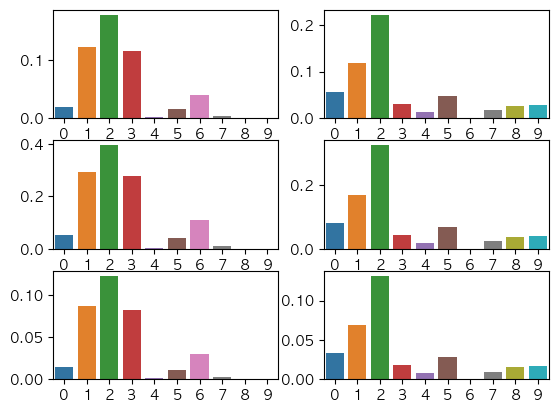

In [5]:
fig,axes = plt.subplots(3,2)
p = X.shape[1]
var_index = [i for i in range(p)]
sns.barplot(ax = axes[0,0],x = var_index,y = bf.get_r_likelihood(X,y,mode="partial",type="mcf"))
sns.barplot(ax = axes[0,1],x = var_index,y = bf.get_r_likelihood(X,y,mode="full",type="mcf"))
sns.barplot(ax = axes[1,0],x = var_index,y = bf.get_r_likelihood(X,y,mode="partial",type="cox"))
sns.barplot(ax = axes[1,1],x = var_index,y = bf.get_r_likelihood(X,y,mode="full",type="cox"))
sns.barplot(ax = axes[2,0],x = var_index,y = bf.get_r_likelihood(X,y,mode="partial",type="tjur"))
sns.barplot(ax = axes[2,1],x = var_index,y = bf.get_r_likelihood(X,y,mode="full",type="tjur"))

In [6]:

lmbd = 0.05
number_samples = 500
number_features = 5
number_influentials = 2
beta_coef = np.concatenate([np.random.normal(5,2,number_influentials),np.zeros(number_features-number_influentials)])
X,y = bf.generate_dependent_sample_logistic(number_samples,number_features,beta_coef,covariance_parameter=30,epsilon=0)
y_type = "binary"


In [7]:
sa_qubo = opt.SimulatedAnnealing("QUBO",y_type=y_type)
sa_qubo_result = sa_qubo.optimize(X,y,lmbd,reps=10)

In [8]:
sa_qubo_result

array([1., 1., 0., 0., 0.])

In [9]:
ga_qubo = opt.GeneticAlgorithm(mode = "QUBO",y_type=y_type)
ga_qubo_result = ga_qubo.optimize(X,y,lmbd)

In [10]:
ga_qubo_result 

array([1, 1, 0, 0, 0])

In [11]:
X_ga_qubo = X[:,test_index.astype(bool)]

In [12]:
X_ga_qubo.shape[1] == 0

False

In [18]:
test_index = np.array([0,0,0,0,0])
X_ga_qubo = X[:,test_index.astype(bool)]
bf.get_QUBO(X_ga_qubo,y,0.05,"binary")

0.600867588668738

In [19]:
test_index = np.array([0,0,0,0,0])
X_ga_qubo = X[:,test_index.astype(bool)]


In [24]:
X_ga_qubo.shape[1] == 0 

True

In [45]:
AIC_list_total =[]
QUBO_list_total = []
MSPE_list_total = []
R2_list_total = []
CN_list_total = []
lmbd = 0.05
number_samples = 500
number_features = 5
number_influentials = 2
number_of_test = 2
for ite in range(number_of_test):
    beta_coef = np.concatenate([np.random.normal(5,2,number_influentials),np.zeros(number_features-number_influentials)])
    X,y = bf.generate_dependent_sample_logistic(number_samples,number_features,beta_coef,covariance_parameter=30,epsilon=0)
    y_type = "binary"


    sa_aic = opt.SimulatedAnnealing(mode = "AIC",y_type=y_type)
    sa_aic_result = sa_aic.optimize(X,y,lmbd,reps=10)
    ga_aic = opt.GeneticAlgorithm(mode = "AIC",y_type=y_type)
    ga_aic_result = ga_aic.optimize(X,y,lmbd)
    sa_qubo = opt.SimulatedAnnealing(mode = "QUBO",y_type=y_type)
    sa_qubo_result = sa_qubo.optimize(X,y,lmbd,reps=10)
    ga_qubo = opt.GeneticAlgorithm(mode = "QUBO",y_type=y_type)
    ga_qubo_result = ga_qubo.optimize(X,y,lmbd)

    X_sa_qubo = X[:,sa_qubo_result.astype(bool)]
    X_ga_qubo = X[:,ga_qubo_result.astype(bool)]
    X_sa_aic = X[:,sa_aic_result.astype(bool)]
    X_ga_aic = X[:,ga_aic_result.astype(bool)]
    datasets = [X,X_sa_aic,X_ga_aic,X_sa_qubo,X_ga_qubo]
    thetasets = [[1 for i in range(p)],sa_aic_result,ga_aic_result,sa_qubo_result,ga_qubo_result]

    AIC_list = []
    QUBO_list = []
    MSPE_list = []
    R2_list = []
    CN_list = []
    for i in range(number_features) :
        dataset = datasets[i]
        theta_temp = thetasets[i]
        AIC_list += [bf.get_aic(dataset,y,y_type=y_type)]
        Q,beta = bf.get_selecting_qubo(X,y,y_type=y_type)
        QUBO_list += [bf.get_QB(theta_temp,Q,beta,lmbd)]
        MSPE_list += [bf.get_accuracy(dataset,y,0.8)]
        R2_list += [bf.get_prediction_R2(dataset,y,0.8,y_type = y_type)]
        CN_list += [bf.get_CN(dataset)]

    AIC_list_total += [AIC_list]
    QUBO_list_total += [QUBO_list]
    MSPE_list_total += [MSPE_list]
    R2_list_total += [R2_list]
    CN_list_total += [CN_list]
    
target = AIC_list_total
AIC_result = pd.DataFrame(target).apply(lambda x: str(round(np.mean(x),2)))+"("+pd.DataFrame(target).apply(lambda x: str(round(np.std(x),2)))+")"
target = QUBO_list_total
QUBO_result = pd.DataFrame(target).apply(lambda x: str(round(np.mean(x),2)))+"("+pd.DataFrame(target).apply(lambda x: str(round(np.std(x),2)))+")"
target = MSPE_list_total
MSPE_result = pd.DataFrame(target).apply(lambda x: str(round(np.mean(x),2)))+"("+pd.DataFrame(target).apply(lambda x: str(round(np.std(x),2)))+")"
target = R2_list_total
R2_result = pd.DataFrame(target).apply(lambda x: str(round(np.mean(x),2)))+"("+pd.DataFrame(target).apply(lambda x: str(round(np.std(x),2)))+")"
target = CN_list_total
CN_result = pd.DataFrame(target).apply(lambda x: str(round(np.mean(x),2)))+"("+pd.DataFrame(target).apply(lambda x: str(round(np.std(x),2)))+")"


result_table = pd.DataFrame([AIC_result,QUBO_result,MSPE_result,R2_result,CN_result])
result_table.columns = ["Original","SA_AIC","GA_AIC","SA_QUBO","GA_QUBO"]
result_table.index = ["AIC_list","QUBO_list","Accuracy","R2","CN"]


random_index = str(random.randrange(0,99999)).zfill(5)

result_table.to_csv("result/simulation_logistic/linear_samples_with_intercept"+random_index+".csv")

print(result_table)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 5 is different from 10)